In [56]:
seed = 0
lr = 1e-3
n_epochs = 10
batch_size = 128
size = 512
n_folds = 5
mixup = 0
foldstop = 1
loss_name = ["bce", "dice"]
gpus = "1"
fold = 0; epoch = 1

import os

from albumentations.augmentations.transforms import GaussNoise, GaussianBlur
os.environ["CUDA_VISIBLE_DEVICES"] = gpus
import logging
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

import re
import cv2
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from apex import amp
import albumentations as A
from segmentation_models_pytorch import Unet
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold

# from utils.dice import DiceLoss, DiceMetric, SqueezeBCELoss
# from utils.lovasz import LovaszLoss, StableBCELoss, SymLovaszLoss
# from utils.mixup import mixup_criterion, mixup_data
# from utils import make_file_path, setup_seed, Log

image_dir = f"data/{size}/train"
mask_dir = f"data/{size}/masks"
# image_dir = mask_dir = "data/test512/train"
images = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
masks = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir)]

df = pd.DataFrame({"images": images, "masks": masks})
df["patient"] = df.images.apply(lambda x: x.split("/")[-1].split("_")[0])

In [78]:
model = Unet("efficientnet-b0")
model.load_state_dict(torch.load("_models/Dec.16_23:26/best/0.pt"))
for p in model.parameters():
    p.requires_grad = False
model = model.cuda()

In [60]:
class Data(Dataset):
    def __init__(self, df, trans = None):
        self.df = df
        self.trans = trans
  
    def __getitem__(self, index):
        image = np.array(Image.open(self.df.images.iloc[index]))
        raw = image.copy()
        mask = np.array(Image.open(self.df.masks.iloc[index]))
#         if (mask - image).round(2).sum() == 0:
#             mask = mask[:,:,0]; mask[:] = 1
        if self.trans is not None:
            aug = self.trans(image = image, mask = mask)
            image = aug["image"]
            mask = aug["mask"]
        image = image.astype(np.float)
        image = image.transpose(2, 0, 1)
        print(self.df.images.iloc[index])
        return raw, image, mask.astype(np.long)
    
    def __len__(self):
        return self.df.shape[0]


# split = GroupKFold(n_folds)
# train_idx, valid_idx = list(split.split(df.patient, groups = df.patient))[fold]
# df_train = df.iloc[train_idx]
# df_valid = df.iloc[valid_idx]
# df = df[df.images.apply(lambda x: "afa5e8098_168.png" in x)]
data = Data(df)

In [61]:
def get():
    for raw, x, y in data:
        if y.sum() != 0:
            yield raw, x, y
gen = get()

data/512/train/1e2425f28_463.png
data/512/train/c68fe75ea_817.png
data/512/train/cb2d976f4_1351.png
data/512/train/8242609fa_594.png
data/512/train/4ef6695ce_363.png


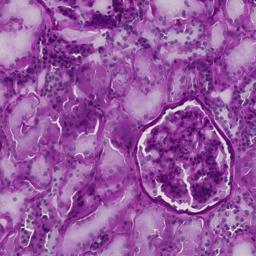

In [156]:
raw, x, y = next(gen)
Image.fromarray(((x - x.min()) / (x.max() - x.min()) * 255).astype(np.uint8).transpose(1, 2, 0)).resize((256, 256))

In [158]:
x = ((x - x.min()) / (x.max() - x.min()) * 255).astype(np.uint8).transpose(1, 2, 0)

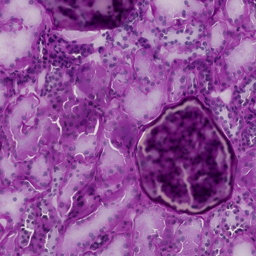

In [221]:
trans = A.Compose([
    A.HueSaturationValue(0, [50, 60], [-50, -40], p = 1),
#     A.(p = 1)
    A.JpegCompression(p = 1),
    A.Blur([5, 10], p = 1),
#     A.
])

z = trans(image = x, mask = y)
xa = z["image"]
ya = z["mask"]
xa[ya == 0] = x[ya == 0]
Image.fromarray(xa).resize((256, 256))

data/test256/afa5e8098_168.png


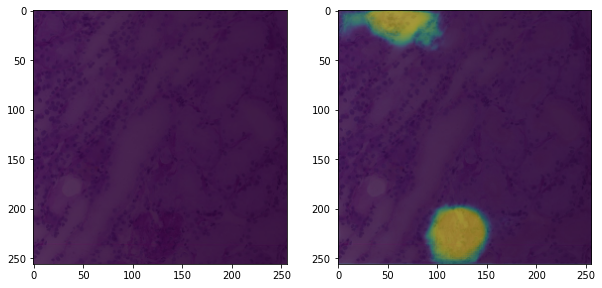

0.1442709291953958


In [81]:
dice = 1
# while dice > 0.85:
raw, x, y = next(gen)
yhat = model(torch.tensor(x).unsqueeze(0).cuda().float())
yhat = yhat.sigmoid().detach().cpu().numpy()[0,0]
yhat[np.abs(x.mean(0) - -4.01543600672611) < 1e-4] = 0
dice = 2 * (yhat.round() * y).sum() / (yhat.round() + y).sum()

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].imshow(raw)
ax[0].imshow(y, alpha = 0.5)
ax[1].imshow(raw)
ax[1].imshow(yhat, alpha = 0.5)
plt.show(fig); plt.close(fig)

print(dice)

In [33]:
np.std(x)

0.5829332198214775